# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from scipy.stats import ks_2samp


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.utils import resample

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

from matplotlib import pyplot

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#azdias = pd.read_csv('azdias.csv')
#customers = pd.read_csv('customers.csv')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

# Step-1 Pre-Processing

In [3]:
print('Reading column names and missing values flags from the xls files provided into a DF')
#I have created columns_and_unknown_flags.csv from the information available in given xls files
#Replace unknown values as per DIAS Attributes - Values 2017.xls with np.nan

columns_and_unknown_flags = pd.read_csv('columns_and_unknown_flags.csv')
#Select columns which are available in azdias DF only
columns_in_df = azdias.columns
#columns_in_df
#Lets check the percent of missing values in each column, columns with lot of missing values may not be useful 
#for further analysis or any ML model. I will drop those columns from the dataframe
print('Total attributes in spreadsheet: {}'.format(columns_and_unknown_flags.shape[0]))
#Consider columns which are available in  DF only
columns_and_unknown_flags = columns_and_unknown_flags[columns_and_unknown_flags['Attribute'].isin(columns_in_df)]
print('Total attributes in DF: {}'.format(columns_and_unknown_flags.shape[0]))

#Replace entries for missing values with np.nan in the DF
missing_value_dict = {}

columns = columns_and_unknown_flags['Attribute'].tolist()
values = columns_and_unknown_flags['Value'].tolist()

for n in range(columns_and_unknown_flags.shape[0]):
    key = columns[n]
    value = values[n].split(';')
    value = [int(i) for i in value] 
    #print(key,value)
    missing_value_dict[key] = value
#missing_value_dict

Reading column names and missing values flags from the xls files provided into a DF


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Total attributes in spreadsheet: 1046548
Total attributes in DF: 223


In [4]:
def clean_df(df):
    '''
    input: pandas dataframe
    output: cleaned pandas df
    
    - Removing columns and rows with more missing values
    - Imputing values in columns when required
    - Replacing missing value flags with nan
    
    '''
    #Check datatype of columns
    print('Below is list of columns and unique values with object datatype')
    for col in df.columns:
        if df[col].dtypes == 'object':
            print(col,' : ',df[col].unique())
    
    
    print('-----------------------------------------------------')
    #LNR seems not a feature in df, hence dropping it
    print('Dropping LNR, CAMEO_DEU_2015 and EINGEFUEGT_AM for now from the dataset')
    df.drop(columns=['LNR'],inplace=True)
    #Dropping CAMEO_DEU_2015 (8A,4C..) and EINGEFUEGT_AM (date time like data) for now 
    df.drop(columns=['CAMEO_DEU_2015'],inplace=True)
    df.drop(columns=['EINGEFUEGT_AM'],inplace=True)
    

    #Replacing values in OST_WEST_KZ
    print('Replacing W:1 and O:0 in OST_WEST_KZ')
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'W':1,'O':0})
    #print('Replacing SINGLE_BUYER:1,MULTI_BUYER:0')
    #df['CUSTOMER_GROUP'] = df['CUSTOMER_GROUP'].replace({'MULTI_BUYER':1,'SINGLE_BUYER':0})
    print('-----------------------------------------------------')
    #Replacing 'X' and 'XX' with np.nan
    print('Replacing X and XX by nan in CAMEO_DEUG_2015 and CAMEO_INTL_2015 respectively')
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X',np.nan)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace('XX',np.nan)
    #After replacing strings with nans, lets convert the data types of these two columns
    #I am not able to convert it into int due to nan values hence converting into float instead
    print('Converting above columns from object to float')
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(float)
    print('-----------------------------------------------------')

    #Replace missing values with np.nan in DF
    print('Replacing missing flags with nans in DF')
    for column in missing_value_dict:
        df[column] = df[column].replace(missing_value_dict[column],np.nan)
    print('-----------------------------------------------------')
    
    azdias_rows_with_missing_values = df.isnull().sum(axis=1)
    #Add column to azdias to count the number of missing rows in all columns
    df['missing_row_percent'] = (azdias_rows_with_missing_values.values/df.shape[1])*100
    #Select all columns with less than 50% missing rows
    print('Size before droppig missing rows: {}'.format(df.shape))
    df = df[df['missing_row_percent'] < 20]
    print('Size after droppig missing rows : {}'.format(df.shape))
    df.drop(columns=['missing_row_percent'],inplace=True)
    print('Cleaning of dataframe completed..')

    return df

In [5]:
def columns_with_missing_values(df):
    print('Analyse missing values in the columns')
    #Lets analyse the percent of missing values in the Df
    #Missing values across rows as well as column

    cols_with_missing = df.isnull().sum()
    # Analyse missing values in each column
    # Load columns and number of missing values in each column to a dataframe
    missingDF = pd.DataFrame(cols_with_missing)

    # Name column which contains number of missing values in each column
    missingDF.columns=['Count_Missing']
    missingDF = missingDF.sort_values(by='Count_Missing',ascending=False)
    missingDF['% Missing Values'] = (missingDF['Count_Missing']/df.shape[0])*100
    # Top 10 columns with missing values
    missingDF = missingDF.head(20)

    # Plot the dataframe to show top 10 columns with most missing values
    sns.set(rc={'figure.figsize':(8,8)})
    sns.barplot(data=missingDF.reset_index(),x="% Missing Values",y="index")
    plt.title("Columns with mising values")
    print('-----------------------------------------------------')
    #Read column names with more than 30% of missing values in a list
    top_columns_with_missing_values = missingDF[missingDF['% Missing Values']>=20].index
    #print('Below columns will be dropped from the dataframe,\n',top_columns_with_missing_values)
    n=1
    for column in top_columns_with_missing_values:
        print('{}. {}'.format(n,column))
        n+=1
    
    return top_columns_with_missing_values

## Clean azdias DF

Below is list of columns and unique values with object datatype
CAMEO_DEU_2015  :  [nan '8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D'
 '9E' '9B' '1B' '3D' '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C'
 'XX']
CAMEO_DEUG_2015  :  [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0 '4' '3' '7' '2' '8' '9' '6' '5'
 '1' 'X']
CAMEO_INTL_2015  :  [nan 51.0 24.0 12.0 43.0 54.0 22.0 14.0 13.0 15.0 33.0 41.0 34.0 55.0 25.0
 23.0 31.0 52.0 35.0 45.0 44.0 32.0 '22' '24' '41' '12' '54' '51' '44' '35'
 '23' '25' '14' '34' '52' '55' '31' '32' '15' '13' '43' '33' '45' 'XX']
D19_LETZTER_KAUF_BRANCHE  :  [nan 'D19_UNBEKANNT' 'D19_SCHUHE' 'D19_ENERGIE' 'D19_KOSMETIK'
 'D19_VOLLSORTIMENT' 'D19_SONSTIGE' 'D19_BANKEN_GROSS'
 'D19_DROGERIEARTIKEL' 'D19_HANDWERK' 'D19_BUCH_CD' 'D19_VERSICHERUNGEN'
 'D19_VERSAND_REST' 'D19_TELKO_REST' 'D19_BANKEN_DIREKT' 'D19_BANKEN_REST'
 'D19_FREIZEIT' 'D19_LEBENSMITTEL' 'D19_HA

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Cleaning of dataframe completed..
Analyse missing values in the columns
-----------------------------------------------------
1. ALTER_KIND4
2. TITEL_KZ
3. ALTER_KIND3
4. ALTER_KIND2
5. ALTER_KIND1
6. AGER_TYP
7. EXTSEL992
8. KK_KUNDENTYP
9. KBA05_BAUMAX
10. ALTER_HH
11. ALTERSKATEGORIE_FEIN
12. D19_BANKEN_ONLINE_QUOTE_12
13. D19_TELKO_ONLINE_QUOTE_12
14. D19_SOZIALES
15. D19_LOTTO
16. D19_LETZTER_KAUF_BRANCHE
17. D19_KONSUMTYP
18. D19_GESAMT_ONLINE_QUOTE_12
19. D19_VERSAND_ONLINE_QUOTE_12
20. D19_VERSI_ONLINE_QUOTE_12
Size before dropping columns: (755529, 363)
Size after dropping columns : (755529, 343)


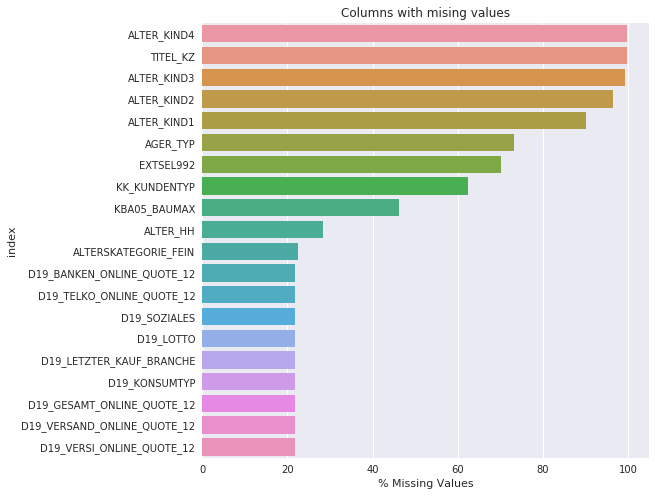

In [6]:
azdias = clean_df(azdias)

azdias_columns_with_missing_values = columns_with_missing_values(azdias)
azdias_columns_with_missing_values

#Drop those columns from the dataframe
print('Size before dropping columns: {}'.format(azdias.shape))
azdias.drop(azdias_columns_with_missing_values, axis=1, inplace=True)
print('Size after dropping columns : {}'.format(azdias.shape))

#Dropping nans from the DF
azdias = azdias.dropna()


## Clean Customer DF

In [7]:
customers = clean_df(customers)

Below is list of columns and unique values with object datatype
CAMEO_DEU_2015  :  ['1A' nan '5D' '4C' '7B' '3B' '1D' '9E' '2D' '4A' '6B' '9D' '8B' '5C' '9C'
 '4E' '6C' '8C' '8A' '5B' '9B' '3D' '2A' '3C' '5F' '7A' '1E' '2C' '7C' '5A'
 '2B' '6D' '7E' '5E' '6E' '3A' '9A' '4B' '1C' '1B' '6A' '8D' '7D' '6F' '4D'
 'XX']
CAMEO_DEUG_2015  :  [1.0 nan 5.0 4.0 7.0 3.0 9.0 2.0 6.0 8.0 '6' '3' '8' '9' '2' '4' '1' '7'
 '5' 'X']
CAMEO_INTL_2015  :  [13.0 nan 34.0 24.0 41.0 23.0 15.0 55.0 14.0 22.0 43.0 51.0 33.0 25.0 44.0
 54.0 32.0 12.0 35.0 31.0 45.0 52.0 '45' '25' '55' '51' '14' '54' '43' '22'
 '15' '24' '35' '23' '12' '44' '41' '52' '31' '13' '34' '32' '33' 'XX']
D19_LETZTER_KAUF_BRANCHE  :  ['D19_UNBEKANNT' 'D19_BANKEN_GROSS' 'D19_NAHRUNGSERGAENZUNG' 'D19_SCHUHE'
 'D19_BUCH_CD' 'D19_DROGERIEARTIKEL' 'D19_SONSTIGE' 'D19_TECHNIK'
 'D19_VERSICHERUNGEN' 'D19_TELKO_MOBILE' 'D19_VOLLSORTIMENT' nan
 'D19_HAUS_DEKO' 'D19_ENERGIE' 'D19_REISEN' 'D19_BANKEN_LOKAL'
 'D19_VERSAND_REST' 'D19_BEKLEIDUNG_REST

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [8]:
#Drop those columns from the dataframe
print('Size before dropping columns: {}'.format(customers.shape))
customers.drop(azdias_columns_with_missing_values, axis=1, inplace=True)
print('Size after dropping columns : {}'.format(customers.shape))



Size before dropping columns: (138213, 366)
Size after dropping columns : (138213, 346)


In [9]:
#Select matching columns from customers df
customers = customers[azdias.columns]

In [10]:
#Dropping nans from the DF
customers = customers.dropna()

In [11]:
azdias.shape

(613447, 343)

In [12]:
customers.shape

(115034, 343)

# Step 2: Feature Transformation

I am using StandarScaling to scale all features in below cells, This will scale each feature so that each column will have mean of 0 and standard deviation of 1.

In [13]:
scaler = StandardScaler()
azdias_scaled_without_column_names = scaler.fit_transform(azdias)
azdias_scaled = pd.DataFrame(azdias_scaled_without_column_names, columns = azdias.columns)

In [14]:
azdias_scaled.head()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.258118,0.189201,-0.127725,-0.298597,0.164502,0.342964,-0.060763,-0.193405,0.865310,0.965327,...,1.396200,0.738954,1.100175,1.486077,-0.682553,0.545727,0.003019,1.153948,0.976612,-1.747173
1,1.258118,0.122332,-0.127725,-0.298597,-0.722965,-0.029236,-0.060763,-0.193405,-0.958782,-0.649562,...,-0.499085,1.090410,0.487038,0.057174,-0.682553,0.545727,-1.064545,1.153948,0.976612,0.200274
2,-0.941773,-0.345752,-0.127725,-0.298597,1.939435,-0.326996,-0.060763,0.813929,-0.958782,0.157882,...,-0.499085,-1.018326,-0.739235,-0.657277,-1.256932,0.545727,-0.530763,0.435490,-1.023948,0.200274
3,-0.941773,-0.212013,-0.127725,-0.298597,-0.722965,-0.401436,-0.060763,-1.200740,0.865310,0.965327,...,-0.499085,1.441865,-0.126098,-0.657277,1.040585,0.545727,1.604367,0.435490,0.976612,-1.747173
4,1.258118,-0.278883,-0.127725,-0.298597,-0.722965,-0.326996,-0.060763,0.813929,0.865310,-0.649562,...,-0.499085,0.387498,0.793607,1.486077,-0.682553,0.545727,0.536802,0.435490,0.976612,-0.773449


In [15]:
# Apply PCA to the data without feeding any number of components.
pca = PCA()
X_pca = pca.fit_transform(azdias_scaled)

In [16]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

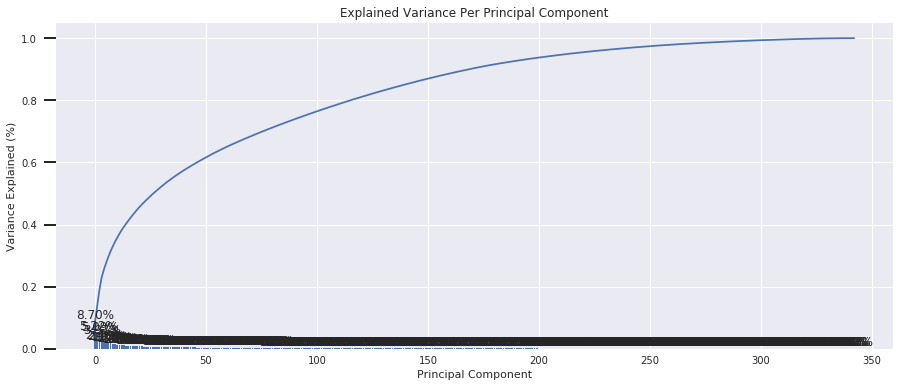

In [17]:
scree_plot(pca)

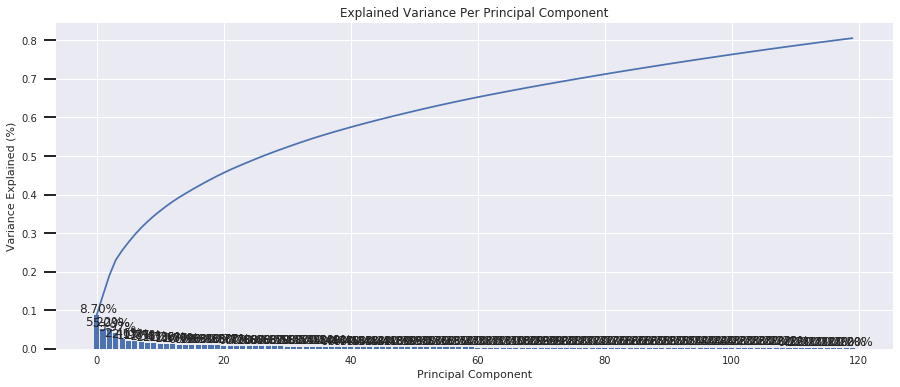

In [18]:
# Apply PCA to the data by feeding n_components as per above scree plot.
n_components=120
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(azdias_scaled)
scree_plot(pca)

In [19]:
# Creating a list of column names for principal components
indices = []
for num in range(n_components):
    indices.append('PCA-'+str(num+1))

In [20]:
# Creating a dataframe using column names for PCs in above step
df_comp = pd.DataFrame(pca.components_,columns=azdias_scaled.columns,index = indices)

Text(0.5,1,'Principal components of general population dataset')

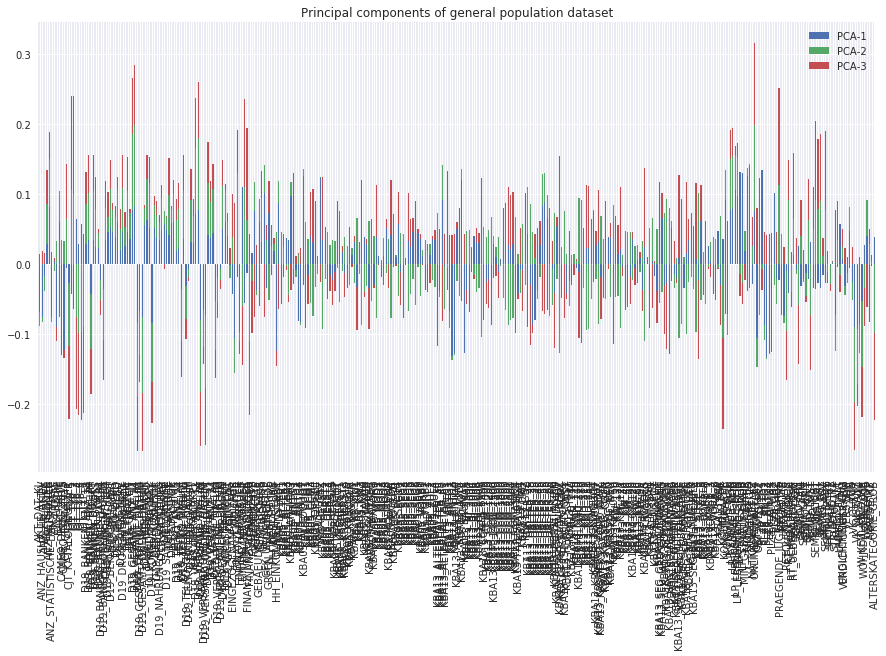

In [21]:
df_comp=df_comp.iloc[0:3]
a4_dims = (15, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
df_comp.T.plot(ax=ax, kind='bar', stacked=True)
plt.title("Principal components of general population dataset")

## Step - 3 Clustering

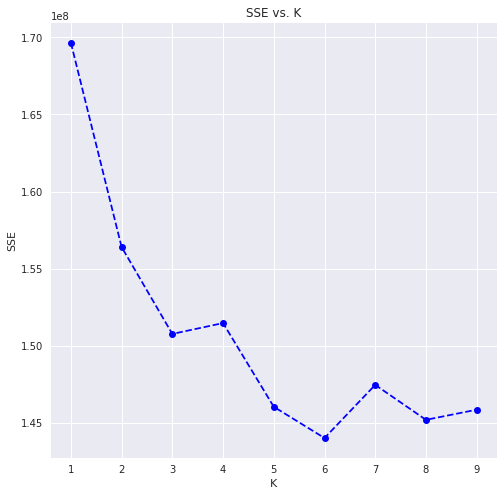

In [22]:
# Elbow test
kPoints=[]
scores=[]
for k in range(1,10):
    kPoints.append(k)
    model_k = MiniBatchKMeans(n_clusters=k,
                             random_state=0,
                             batch_size=10,
                             max_iter=10).fit(X_pca)

    #kmeans_k = KMeans(n_clusters=k)
    #model_k = kmeans_k.fit(X_pca)
    labels_k = model_k.predict(X_pca)
    scores.append(abs(model_k.score(X_pca)))
    #print(k,abs(model_k.score(X_pca)))
    
# Obtain the score for each model (take the absolute value)
# Plot the score against k
plt.rcParams['figure.figsize'] = [8, 8]
plt.plot(kPoints, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [24]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k=6
kmeans_k = KMeans(n_clusters=k)
model_k = kmeans_k.fit(X_pca)
labels_k = model_k.predict(X_pca)
score = model_k.score(X_pca)

In [25]:
# Checking whether cluster for all datapoints has been predicted by model
print(len(labels_k))
print(X_pca.shape)

613447
(613447, 120)


In [26]:
# Adding columns names for principal components
general_pca_df = pd.DataFrame()
for i in range(len(indices)):
    #print(indices[i],i)
    general_pca_df[indices[i]]=X_pca[:,i]
general_pca_df.shape

(613447, 120)

In [27]:
# Adding labels predicted in above steps to dataset with PCA
general_pca_df['Cluster'] = pd.Series(labels_k, index=general_pca_df.index)
general_pca_df.head()

,PCA-1,PCA-2,PCA-3,PCA-4,PCA-5,PCA-6,PCA-7,PCA-8,PCA-9,PCA-10,...,PCA-112,PCA-113,PCA-114,PCA-115,PCA-116,PCA-117,PCA-118,PCA-119,PCA-120,Cluster
0,-4.531010,-1.935338,6.532559,-5.454441,0.448408,-1.851331,4.683960,0.425144,-0.622927,-1.858838,...,-0.189652,-0.043014,-1.666167,-0.650442,1.284757,-0.453607,-0.480528,0.452124,1.547325,4
1,0.214849,-2.764190,1.256612,-3.279595,4.242503,-4.355423,-4.761565,-1.913623,1.744736,0.736696,...,0.686177,0.219850,1.562938,-0.479206,-0.651748,-0.731214,0.869971,-0.587423,-0.062879,4
2,4.588533,4.597590,6.452463,7.456522,-3.292345,2.980140,-2.605486,-3.199912,-0.178357,-3.840472,...,2.605899,-1.205052,-0.946354,0.169130,1.015934,-1.265711,0.970997,1.075370,1.106820,0
3,2.244964,-3.158022,-0.395032,-2.976470,1.451536,0.256840,0.770079,-2.247126,0.648682,-2.413752,...,0.044200,-0.148564,0.116508,-0.689878,0.274666,-0.344706,-0.349980,-0.420166,1.334191,3
4,-2.406379,1.986973,-0.601037,-6.810918,-0.702937,-2.986244,-4.919533,0.578570,0.270986,1.473082,...,0.218343,0.147192,0.720763,-0.863395,0.233151,0.893712,0.222281,-0.041085,0.151651,4


In [28]:
#Inverse pca and then inverse scaler to X_pca
# pca and scaler are the object initialised by PCA and Scaler
# After pca inverse transform we will get scaled dataset
scaled_general_demographic = pca.inverse_transform(X_pca)
scaled_general_demographic = pd.DataFrame(scaled_general_demographic, columns = azdias.columns)
scaled_general_demographic.head()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.344156,0.484492,-0.215698,0.378359,0.480346,0.503887,0.026619,-0.181661,0.967433,1.342505,...,0.986623,0.386599,0.641968,0.839912,-0.434722,0.364019,-0.254551,0.683162,0.968140,-1.625248
1,0.721312,-0.039425,0.006043,-0.597371,-0.609141,-0.014235,-0.518611,-0.054132,-0.634886,-1.085057,...,-0.930056,0.611336,0.475995,0.328402,-0.060364,0.811506,-0.709052,0.977136,1.100872,0.166365
2,-0.377015,-0.510823,0.187209,-0.656491,1.748437,-0.505529,-0.489618,0.689031,-0.918018,0.438202,...,-0.577253,-1.415079,-1.191430,-0.950678,-0.890029,0.525144,-0.304176,0.254861,-1.336771,0.462176
3,-1.134324,-0.308493,0.189186,-0.436543,-0.768949,-0.282775,-0.306083,-0.742783,0.945159,0.351595,...,-0.181021,0.436585,0.231039,0.051124,1.151359,0.943120,1.118449,0.681685,0.469181,-1.520291
4,1.104533,-0.283006,-0.105634,-0.082286,-0.745399,-0.278586,0.045883,0.289373,1.097769,-1.041107,...,0.120975,0.915560,1.287307,1.466995,-0.183397,0.091367,-0.112244,0.650796,0.957924,-1.011440


In [29]:
#Adding labels to general population dataset
azdias['Cluster'] = pd.Series(labels_k, index=azdias.index)
azdias.head()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Cluster
1,9.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8.0,...,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1,4
2,9.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,4.0,...,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3,4
4,1.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,6.0,...,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3,0
5,1.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,8.0,...,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1,3
6,9.0,4.0,0.0,0.0,1.0,3.0,0.0,4.0,6.0,4.0,...,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2,4


In [30]:
# Creating dataframe to store datapoints in each cluster for general population dataset
general_cluster_df = pd.DataFrame()
general_cluster_dict = {i: np.where(labels_k == i)[0] for i in range(model_k.n_clusters)}
for key, value in general_cluster_dict.items():
    #print value
    val=len([item for item in value if item])
    general_cluster_df = general_cluster_df.append({'Cluster_ID':int(key),'General_Datapoints':val}, \
                                                   ignore_index=True)
general_cluster_df.head()

,Cluster_ID,General_Datapoints
0,0.0,113372.0
1,1.0,98871.0
2,2.0,79519.0
3,3.0,115842.0
4,4.0,109462.0


In [31]:
# Scaling customer dataset using same scaler obect used above for general population dataset
# transform() function has been used instead of fit_transform()

customers_scaled_without_column_names = scaler.transform(customers)

# Creating a dataframe with columns names to the scaled dataset
customers_scaled = pd.DataFrame(customers_scaled_without_column_names, columns = customers.columns)
customers_scaled.head()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-0.941773,-0.479490,-0.127725,-0.298597,0.164502,-0.475876,-0.060763,-2.208074,-0.502759,-1.860728,...,0.448557,-0.315414,-1.352371,-1.371729,1.040585,0.545727,1.604367,-0.282968,-1.023948,1.173998
1,-0.941773,-0.479490,-0.127725,-0.298597,-0.722965,-0.475876,-0.060763,-0.193405,1.321333,-0.245840,...,1.396200,1.441865,1.713311,1.843303,1.040585,0.545727,-1.064545,-0.282968,0.976612,1.173998
2,-0.941773,-0.078275,-0.127725,-0.298597,1.939435,-0.029236,-0.060763,-0.193405,-0.502759,0.561605,...,1.396200,-1.018326,-0.739235,-0.657277,-1.256932,0.545727,-0.530763,-1.719884,-1.023948,0.200274
3,-0.941773,-0.479490,-0.127725,-0.298597,0.164502,-0.475876,-0.060763,-0.193405,1.321333,-0.245840,...,1.396200,-1.721238,-1.658939,-1.728954,1.040585,0.545727,-1.598328,-1.001426,-1.023948,0.200274
4,-0.941773,-0.479490,-0.127725,-0.298597,0.164502,-0.475876,-0.060763,-1.200740,0.865310,-1.053284,...,1.396200,-1.018326,-1.045803,-1.371729,1.040585,0.545727,1.604367,-1.719884,-1.023948,1.173998


Text(0.5,1,'Principal components of customer dataset')

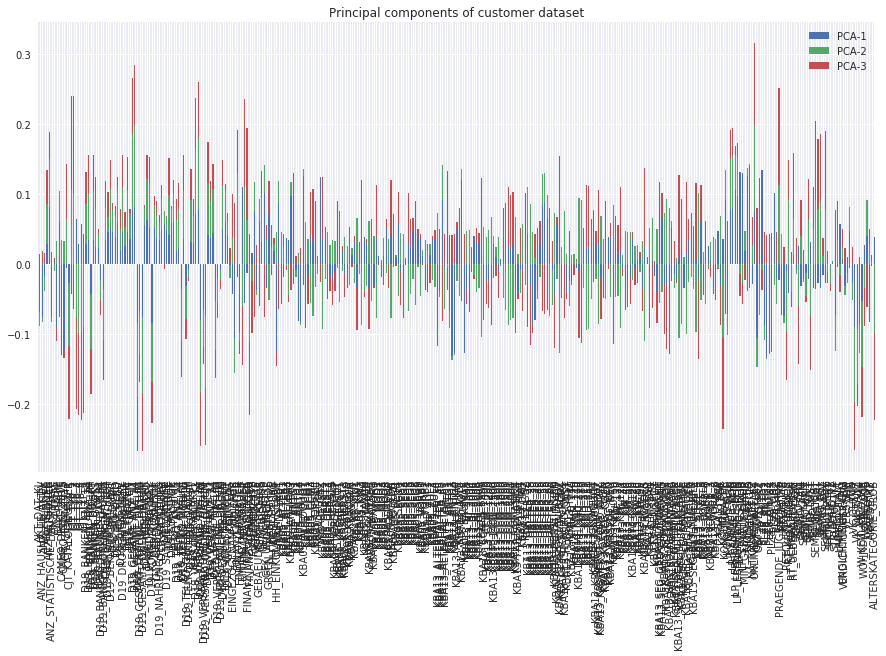

In [32]:
# Getting principal components of customer cluster by using pca object from general population dataset
# using only transform() instead of fit_transform()

Xcust_pca = pca.transform(customers_scaled)
Xcust_pca_col = pd.DataFrame(Xcust_pca,columns=indices)
df_custcomp = pd.DataFrame(pca.components_,columns=customers_scaled.columns,index = indices)
df_custcomp=df_custcomp.iloc[0:3]
a4_dims = (15, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
df_custcomp.T.plot(ax=ax, kind='bar', stacked=True)
plt.title("Principal components of customer dataset")

In [33]:
cust_pca_df = pd.DataFrame()
for i in range(len(indices)):
    #print(indices[i],i)
    cust_pca_df[indices[i]]=Xcust_pca[:,i]
cust_pca_df.head()

,PCA-1,PCA-2,PCA-3,PCA-4,PCA-5,PCA-6,PCA-7,PCA-8,PCA-9,PCA-10,...,PCA-111,PCA-112,PCA-113,PCA-114,PCA-115,PCA-116,PCA-117,PCA-118,PCA-119,PCA-120
0,8.567354,-6.870155,-1.990227,-0.656660,-1.303069,3.339340,-0.702673,-0.063935,0.051965,-1.322474,...,1.405310,-0.014972,-0.024416,1.082657,-0.708797,1.431447,0.130868,0.982105,-0.708606,0.028046
1,-0.984688,-6.930426,-2.390503,2.856420,-3.865192,-1.097481,-0.840048,2.090903,-6.583858,-0.702172,...,-1.640082,0.774549,-1.343469,0.196826,-0.261010,-0.397211,0.034091,0.565233,-0.798486,0.648368
2,1.789263,6.570937,3.047337,4.818754,-4.960208,1.131967,-0.794524,0.095984,2.360703,-2.545689,...,0.168385,-0.256594,0.006636,-0.078337,0.916921,0.586451,0.938565,1.633205,0.821731,0.546232
3,4.976282,-8.469080,2.902983,4.602745,0.945053,2.689794,-1.623302,0.086303,-3.048211,-0.652189,...,-0.020482,-0.938123,-0.056807,0.533743,1.080653,-2.427014,0.619716,-1.577229,0.946991,-0.750170
4,9.138369,-2.243899,-1.807262,1.629695,-2.885416,2.928167,-0.103863,-0.967879,-1.419665,-3.802095,...,-1.253255,-0.779697,-2.433501,0.819794,-1.437997,1.207511,-0.138744,0.010277,-0.465957,1.890091


In [34]:
general_pca_df = pd.DataFrame()
for i in range(len(indices)):
    #print(indices[i],i)
    general_pca_df[indices[i]]=X_pca[:,i]
general_pca_df.head()

,PCA-1,PCA-2,PCA-3,PCA-4,PCA-5,PCA-6,PCA-7,PCA-8,PCA-9,PCA-10,...,PCA-111,PCA-112,PCA-113,PCA-114,PCA-115,PCA-116,PCA-117,PCA-118,PCA-119,PCA-120
0,-4.531010,-1.935338,6.532559,-5.454441,0.448408,-1.851331,4.683960,0.425144,-0.622927,-1.858838,...,-0.101519,-0.189652,-0.043014,-1.666167,-0.650442,1.284757,-0.453607,-0.480528,0.452124,1.547325
1,0.214849,-2.764190,1.256612,-3.279595,4.242503,-4.355423,-4.761565,-1.913623,1.744736,0.736696,...,-0.808430,0.686177,0.219850,1.562938,-0.479206,-0.651748,-0.731214,0.869971,-0.587423,-0.062879
2,4.588533,4.597590,6.452463,7.456522,-3.292345,2.980140,-2.605486,-3.199912,-0.178357,-3.840472,...,0.070585,2.605899,-1.205052,-0.946354,0.169130,1.015934,-1.265711,0.970997,1.075370,1.106820
3,2.244964,-3.158022,-0.395032,-2.976470,1.451536,0.256840,0.770079,-2.247126,0.648682,-2.413752,...,0.856774,0.044200,-0.148564,0.116508,-0.689878,0.274666,-0.344706,-0.349980,-0.420166,1.334191
4,-2.406379,1.986973,-0.601037,-6.810918,-0.702937,-2.986244,-4.919533,0.578570,0.270986,1.473082,...,1.270966,0.218343,0.147192,0.720763,-0.863395,0.233151,0.893712,0.222281,-0.041085,0.151651


In [35]:
# Predict customer labels using model created on general population dataset

cust_labels_k = model_k.predict(Xcust_pca)
cust_score = model_k.score(Xcust_pca)

In [36]:
scaled_customers_data = pca.inverse_transform(Xcust_pca)
scaled_customers_data = pd.DataFrame(scaled_customers_data, columns = customers.columns)

In [37]:
print(len(cust_labels_k))
print(cust_pca_df.shape)

115034
(115034, 120)


In [38]:
# Adding labels to customer original dataset
customers['Cluster'] = pd.Series(cust_labels_k, index=customers.index)
customers.head()

,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,Cluster
0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,1.0,...,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4,3
2,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,5.0,...,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4,2
4,1.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,7.0,...,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3,0
5,1.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,7.0,5.0,...,1.0,2.0,1.0,6.0,9.0,1.0,2,1,3,2
6,1.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,6.0,3.0,...,3.0,4.0,2.0,6.0,9.0,7.0,1,1,4,3


In [39]:
customer_cluster_df = pd.DataFrame()
customer_cluster_dict = {i: np.where(cust_labels_k == i)[0] for i in range(model_k.n_clusters)}
for key, value in customer_cluster_dict.items():
    #print value
    val=len([item for item in value if item])
    customer_cluster_df = customer_cluster_df.append({'Cluster_ID':int(key),'Cust_Datapoints':val}, ignore_index=True)

In [40]:
#Function to plot top 10 and bottom 10 features for given cluster from scaled dataset
def plot_scaled_comparison(scaled_customers_data, model_k, cluster):
    a4_dims = (5, 6)
    fig, ax = plt.subplots(figsize=a4_dims)
    X = pd.DataFrame.from_dict(dict(zip(scaled_customers_data.columns,
                                        pca.inverse_transform(model_k.cluster_centers_[cluster]))), orient='index').rename(
    columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)
    X['feature_values_abs'] = abs(X['feature_values'])
    pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0).plot(kind='barh');

In [41]:
gen_cust_clusters = pd.merge(general_cluster_df,customer_cluster_df,on='Cluster_ID')
gen_cust_clusters

,Cluster_ID,General_Datapoints,Cust_Datapoints
0,0.0,113372.0,31585.0
1,1.0,98871.0,3672.0
2,2.0,79519.0,30194.0
3,3.0,115842.0,37953.0
4,4.0,109462.0,1297.0
5,5.0,96380.0,10332.0


In [42]:
gen_cust_clusters['General_Proportion']= \
gen_cust_clusters['General_Datapoints']/gen_cust_clusters['General_Datapoints'].sum()
gen_cust_clusters['Customer_Proportion']= \
gen_cust_clusters['Cust_Datapoints']/gen_cust_clusters['Cust_Datapoints'].sum()

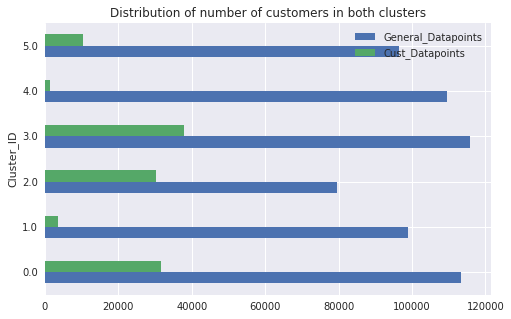

In [43]:
plt.rcParams['figure.figsize'] = [8, 5]
gen_cust_clusters[["Cluster_ID", "General_Datapoints", 
                   "Cust_Datapoints"]].plot(x="Cluster_ID", kind="barh",
                                               title='Distribution of number of customers in both clusters')

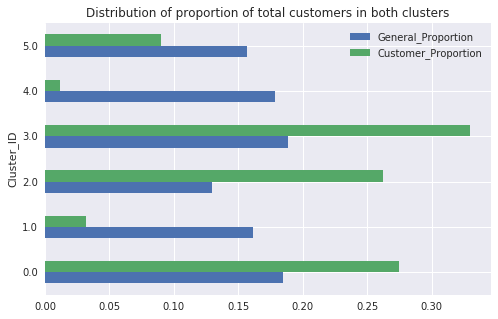

In [44]:
gen_cust_clusters[["Cluster_ID", "General_Proportion", 
                   "Customer_Proportion"]].plot(x="Cluster_ID", kind="barh",
                                               title='Distribution of proportion of total customers in both clusters')

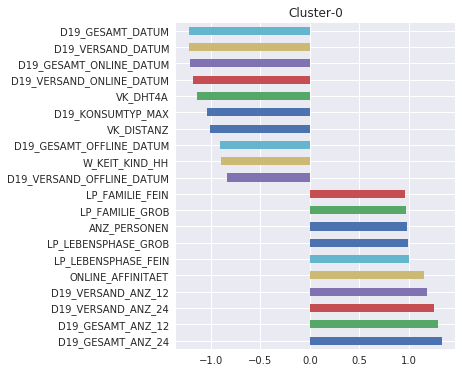

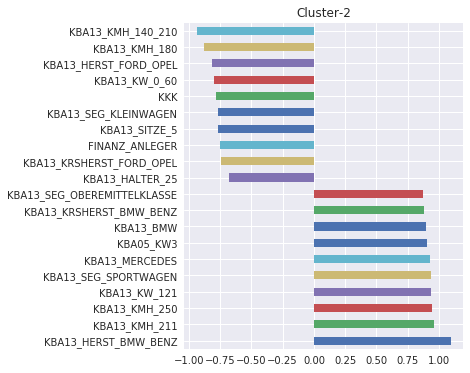

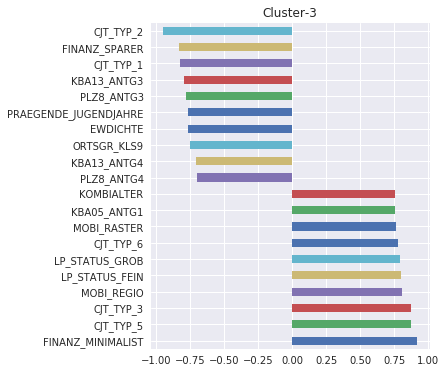

In [46]:
# Lets plot both type of clusters where customers are overrepresented as well as underrepresented as 
# compared to general demographic dataset
for k in [0,2,3]:
    plot_scaled_comparison(scaled_customers_data, model_k, k)
    plt.title('Cluster-'+str(k))

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [47]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [48]:
#Check whether class is imbalanced
mailout_train.groupby('RESPONSE').count()['LNR']

RESPONSE
0    42430
1      532
Name: LNR, dtype: int64

In [49]:
def preprocess_supervised_dataset(mailout_train):
    #Check datatype of columns
    print('Below is list of columns and unique values with object datatype')
    i=1
    for col in mailout_train.columns:
        if mailout_train[col].dtypes == 'object':
            print(i,':',col,' : ',mailout_train[col].unique())
            i+=1
            
    #Below columns can be converted into float after replacing unknown string by np.nan
    # 2 : CAMEO_DEUG_2015
    # 3 : CAMEO_INTL_2015

    print('Replacing X and XX by nan in CAMEO_DEUG_2015 and CAMEO_INTL_2015 respectively')
    mailout_train['CAMEO_DEUG_2015'] = mailout_train['CAMEO_DEUG_2015'].replace('X',np.nan)
    mailout_train['CAMEO_INTL_2015'] = mailout_train['CAMEO_INTL_2015'].replace('XX',np.nan)
    #After replacing strings with nans, lets convert the data types of these two columns
    #I am not able to convert it into int due to nan values hence converting into float instead
    print('Converting above columns from object to float')
    mailout_train['CAMEO_DEUG_2015'] = mailout_train['CAMEO_DEUG_2015'].astype(float)
    mailout_train['CAMEO_INTL_2015'] = mailout_train['CAMEO_INTL_2015'].astype(float)

    #Below columns seems datetime, this can be removed as it may not be a good candidate as a feature
    # 5 : EINGEFUEGT_AM
    print('Dropping EINGEFUEGT_AM as it seems datetime')
    mailout_train.drop(columns=['EINGEFUEGT_AM'],inplace=True)

    #Binary feature in below column which can be replaced by 0 and 1
    # 6 : OST_WEST_KZ 

    print('Replacing W:1 and O:0 in OST_WEST_KZ')
    mailout_train['OST_WEST_KZ'] = mailout_train['OST_WEST_KZ'].replace({'W':1,'O':0})
    
    #Dropping above two columns as well for now as we have sufficient features left to train the model
    print('Dropping CAMEO_DEU_2015 and D19_LETZTER_KAUF_BRANCHE')
    mailout_train.drop(columns=['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE'], inplace=True)
    

    print('Dropping LNR')
    mailout_train.drop(columns=['LNR'],inplace=True)
    return mailout_train

In [50]:
mailout_train = preprocess_supervised_dataset(mailout_train)

Below is list of columns and unique values with object datatype
1 : CAMEO_DEU_2015  :  ['5D' '5B' '2D' '7B' '4C' '5C' nan '3D' '5A' '2C' '4A' '6B' '1A' '8D' '4B'
 '7A' '4E' '3A' '7C' '9D' '8A' '5E' '8B' '3C' '6E' '4D' '2B' '3B' '7E' '2A'
 '6C' '1C' '6D' '7D' '1D' '8C' '9A' '9B' '9C' '9E' '6F' '1E' '6A' '5F' '1B'
 'XX']
2 : CAMEO_DEUG_2015  :  [5.0 2.0 7.0 4.0 nan 3.0 6.0 1.0 8.0 9.0 '4' '6' '2' '9' '8' '7' '3' '1'
 '5' 'X']
3 : CAMEO_INTL_2015  :  [34.0 32.0 14.0 41.0 24.0 33.0 nan 25.0 31.0 22.0 43.0 13.0 55.0 23.0 54.0
 51.0 45.0 12.0 44.0 35.0 15.0 52.0 '23' '44' '14' '55' '51' '45' '43' '22'
 '54' '24' '25' '13' '12' '35' '33' '41' '15' '52' '31' '32' '34' 'XX']
4 : D19_LETZTER_KAUF_BRANCHE  :  ['D19_UNBEKANNT' 'D19_TELKO_MOBILE' 'D19_LEBENSMITTEL' 'D19_BEKLEIDUNG_GEH'
 'D19_BUCH_CD' nan 'D19_NAHRUNGSERGAENZUNG' 'D19_SCHUHE' 'D19_SONSTIGE'
 'D19_HAUS_DEKO' 'D19_FREIZEIT' 'D19_ENERGIE' 'D19_VOLLSORTIMENT'
 'D19_BANKEN_REST' 'D19_VERSICHERUNGEN' 'D19_KINDERARTIKEL' 'D19_TECHNIK'
 'D1

In [51]:
mailout_train.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,0.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,NaN,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,0.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,0.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


Analyse missing values in the columns
-----------------------------------------------------
1. ALTER_KIND4
2. ALTER_KIND3
3. ALTER_KIND2
4. ALTER_KIND1
5. KK_KUNDENTYP
6. EXTSEL992
7. HH_DELTA_FLAG
8. W_KEIT_KIND_HH
9. KBA05_KRSHERST1
10. KBA05_HERST1
11. KBA05_HERST2
12. KBA05_HERST3
13. KBA05_HERST4
14. KBA05_HERST5
15. KBA05_KRSAQUOT
16. KBA05_KRSZUL
17. KBA05_KRSHERST2
18. KBA05_KRSHERST3
19. KBA05_KRSKLEIN
20. KBA05_FRAU


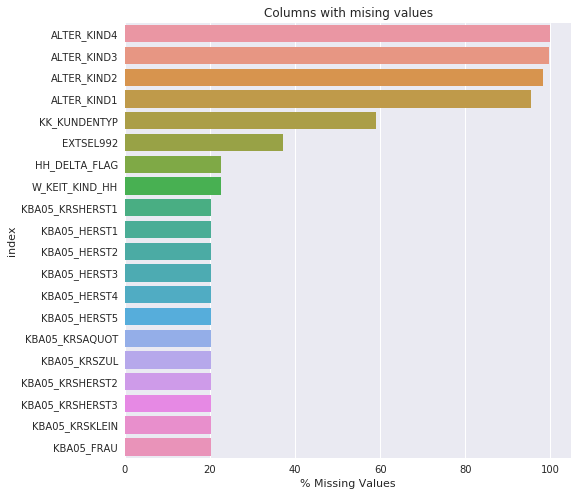

In [52]:
cols_to_be_dropped = columns_with_missing_values(mailout_train)
mailout_train.drop(columns=cols_to_be_dropped,inplace=True)

In [53]:
mailout_train_ns = mailout_train[mailout_train['RESPONSE']==0]
mailout_train_ps = mailout_train[mailout_train['RESPONSE']==1]


In [54]:
mailout_train_ns.shape

(42430, 343)

In [55]:
mailout_train_ns.dropna(inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [56]:
mailout_train_ns.shape

(30811, 343)

In [57]:
mailout_train = mailout_train_ns.append(mailout_train_ps)

In [58]:
mailout_train.shape

(31343, 343)

In [59]:
mailout_train = mailout_train.fillna(0)

In [60]:
mailout_train.groupby('RESPONSE').count()['AGER_TYP']

RESPONSE
0    30811
1      532
Name: AGER_TYP, dtype: int64

In [61]:
# Up-sample Minority Class
# Separate majority and minority classes
df_majority = mailout_train[mailout_train.RESPONSE==0]
print('Size of majority DF: {}'.format(df_majority.shape))
df_minority = mailout_train[mailout_train.RESPONSE==1]
print('Size of minority DF: {}'.format(df_minority.shape))

Size of majority DF: (30811, 343)
Size of minority DF: (532, 343)


In [62]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=30811,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.RESPONSE.value_counts()

1    30811
0    30811
Name: RESPONSE, dtype: int64

In [63]:
# Separate input features (X) and target variable (y)
y = df_upsampled.RESPONSE
X = df_upsampled.drop('RESPONSE', axis=1)


In [64]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)

In [65]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# import machine learning algorithms
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# TODO: Initialize the three models
classifiers = []
clf_A = AdaBoostClassifier(base_estimator = DecisionTreeClassifier())
classifiers.append(clf_A)
clf_B = GradientBoostingClassifier()
classifiers.append(clf_B)
clf_C = RandomForestClassifier()
classifiers.append(clf_C)
classifiers

[AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='best'),
           learning_rate=1.0, n_estimators=50, random_state=None),
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100,
               presort='auto', random_state=None, subsample=1.0, verbose=0,
               warm_start=False),
 RandomForestClassifier(bootst

No Skill: ROC AUC=0.500
AdaBoostClassifier : ROC AUC=0.987


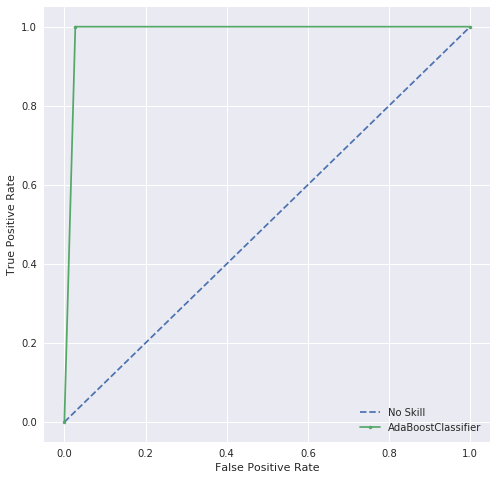

             precision    recall  f1-score   support

          0       1.00      0.97      0.99     15488
          1       0.97      1.00      0.99     15323

avg / total       0.99      0.99      0.99     30811

No Skill: ROC AUC=0.500
GradientBoostingClassifier : ROC AUC=0.952


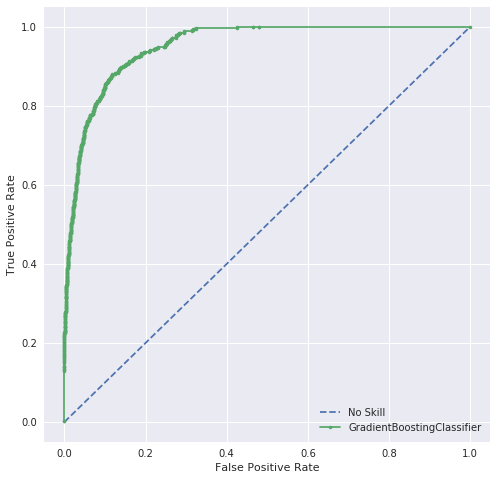

             precision    recall  f1-score   support

          0       0.93      0.80      0.86     15488
          1       0.82      0.94      0.88     15323

avg / total       0.87      0.87      0.87     30811

No Skill: ROC AUC=0.500
RandomForestClassifier : ROC AUC=1.000


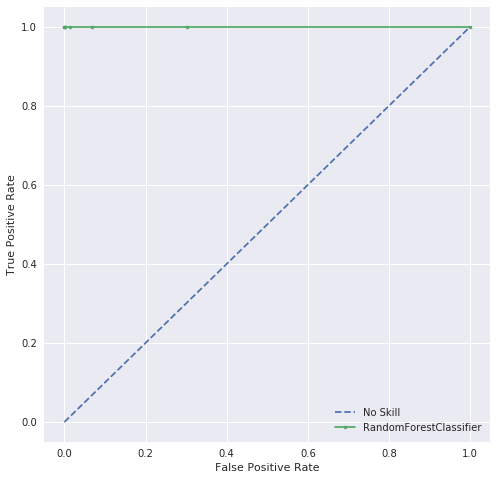

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     15488
          1       1.00      1.00      1.00     15323

avg / total       1.00      1.00      1.00     30811



In [66]:
clf_names = ['AdaBoostClassifier','GradientBoostingClassifier','RandomForestClassifier']
for num in range(len(classifiers)):
    clf = classifiers[num]
    clf.fit(trainX,trainy)
    predy = clf.predict(testX)
    acc = accuracy_score(testy,predy.round())
    #print('Accuracy of %s is %s'%(clf_names[num],acc))
    cm = confusion_matrix(testy,predy.round())
    #print('Confusion Matrix of %s is %s'%(clf_names[num],cm))
    #print("Classification Report")
    
    #Plot ROC-AUC curve
    ns_probs = [0 for _ in range(len(testy))]
    # predict probabilities
    lr_probs = classifiers[num].predict_proba(testX)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, lr_probs)
   # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print(clf_names[num],': ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label=clf_names[num])
   # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    print(classification_report(testy, predy.round()))
    

In [67]:
# Train model
clf_4 = GradientBoostingClassifier()
#clf_4 = RandomForestClassifier()
clf_4.fit(X, y)
 
# Predict on training set
pred_y_4 = clf_4.predict(X)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_4 ) )
# [0 1]
 
# How's our accuracy?
#print( accuracy_score(y, pred_y_4) )
# 0.9744
 
# What about AUROC?
prob_y_4 = clf_4.predict(X)
#prob_y_4 = [p[1] for p in prob_y_4]
#print( roc_auc_score(y, prob_y_4) )
# 0.99907879



[0 1]


In [68]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score

In [69]:
param_test = {'n_estimators':range(20,81,10)}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score,beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf_4,param_test,scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(trainX,trainy)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(trainX,trainy)).predict(testX)
best_predictions = best_clf.predict(testX)

In [70]:
best_clf

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [71]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [72]:
LNR = mailout_test['LNR']

In [73]:
mailout_test = preprocess_supervised_dataset(mailout_test)

Below is list of columns and unique values with object datatype
1 : CAMEO_DEU_2015  :  ['2B' '5A' '7A' '9D' '4E' '6B' '2D' '1D' '7E' '4C' nan '1C' '4A' '5F' '6D'
 '3C' '9B' '6C' '8B' '3D' '5D' '1A' '3A' '7B' '2C' '8A' '6F' '2A' '5B' '6E'
 '5C' '8D' '4D' '8C' '9E' '7C' '9A' '6A' '9C' '1B' '3B' '7D' '1E' 'XX' '4B'
 '5E']
2 : CAMEO_DEUG_2015  :  ['2' '5' '7' '9' '4' '6' '1' nan '3' '8' 'X' 3.0 4.0 8.0 6.0 2.0 5.0 7.0
 9.0 1.0]
3 : CAMEO_INTL_2015  :  ['13' '31' '41' '51' '25' '43' '14' '15' '45' '24' nan '22' '35' '44' '34'
 '23' '12' '32' '33' '55' '54' '52' 'XX' 25.0 23.0 41.0 45.0 51.0 14.0 13.0
 24.0 22.0 43.0 54.0 31.0 44.0 52.0 35.0 15.0 32.0 34.0 12.0 55.0 33.0]
4 : D19_LETZTER_KAUF_BRANCHE  :  ['D19_BEKLEIDUNG_GEH' 'D19_UNBEKANNT' 'D19_LEBENSMITTEL' 'D19_BANKEN_GROSS'
 'D19_SONSTIGE' 'D19_HAUS_DEKO' 'D19_VERSICHERUNGEN' 'D19_BUCH_CD'
 'D19_VERSAND_REST' 'D19_BEKLEIDUNG_REST' 'D19_VOLLSORTIMENT' 'D19_ENERGIE'
 'D19_DROGERIEARTIKEL' 'D19_WEIN_FEINKOST' nan 'D19_TELKO_MOBILE'
 'D19_H

In [74]:
mailout_test = mailout_test.fillna(0)
mailout_test.drop(columns=cols_to_be_dropped,inplace=True)
# Predict on testing data set
pred_y_4 = best_clf.predict(mailout_test)
 
# Is our model still predicting just one class?
print( np.unique( pred_y_4 ) )
# [0 1]
 

[0 1]


In [75]:
unique, counts = np.unique(pred_y_4, return_counts=True)
dict(zip(unique, counts))

{0: 26555, 1: 16278}

In [76]:
prob_y_4 = clf_4.predict(mailout_test)
#prob_y_4 = [p[1] for p in prob_y_4]

In [77]:
prob_dict = {'LNR':LNR, 'RESPONSE':prob_y_4}
df = pd.DataFrame(prob_dict)
df.head()

,LNR,RESPONSE
0,1754,1
1,1770,1
2,1465,0
3,1470,0
4,1478,0


In [78]:
df.to_csv('submission.csv',index=False)